# Mod 4 Project - Image Classification

* Student name: Alex Beat
* Student pace: part time
* Scheduled project review date/time: 06/24/20 @12pm pacific
* Instructor name: James Irving
* Blog post URL: NA

# Intro

* Problem: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.
* Audience: Medical business, imaging labs. 
* Business Questions: How can a successful model help save medical professionals time, money and promote better accuracy in patient diagnosis. 

## Content
The dataset is organized into 2 folders (train, test) and contains subfolders for each image category (Pneumonia/Normal). There are 5,385 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

(Content info and dataset provided by Paul Mooney on Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia?)

# Select Colab directory and unzip virtually in colab.

This first section will help those who want to or need to run Keras and Tensorflow in Colab. I was forced to run my notebooks in the cloud using Colab because my OS was too old and wouldn't run the necesary versions of Keras. Working with Colab is very fast with image loading, as long as you set it up correctly. If not, it will be slower than a notebook on your own machine. This blog post was used to help load in your entire zip file and virtually unzip your image files in one move in colab as opposed to how Colab normally would load in each image individually: https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

### Mount google drive connection to colab. 

In [ ]:
from google.colab import drive

# choose your drive file path
drive.mount('/content/drive', force_remount=True)

# cd to the uppermost folder in gdrive to save your zip file
%cd ~
%cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/root
/


### Create file paths

In [ ]:
import os,glob

# check current directory to see if you're at the top
print(os.path.abspath(os.curdir))

# file path to save your zip file dataset
source_folder = r'content/drive/My Drive/Datasets/'

# variable for your filename
file = glob.glob(source_folder+'xray.zip',recursive=True)[0]
file

/


'content/drive/My Drive/Datasets/xray.zip'

### Zip virtual copy/unzip/removal.

In [ ]:
# variable for the path
zip_path = file

# copies the zip file
!cp "{zip_path}" .

# unzip file virtually in colab
!unzip -q xray.zip

# removes copied zip
!rm xray.zip

In [ ]:
# check directory to see virtual files are in your main folder
import os,glob
print(os.path.abspath(os.curdir))
os.listdir()


/


['lib',
 'dev',
 'etc',
 'sbin',
 'root',
 'sys',
 'proc',
 'home',
 'usr',
 'var',
 'tmp',
 'run',
 'srv',
 'lib64',
 'boot',
 'bin',
 'opt',
 'mnt',
 'media',
 'xray',
 'content',
 '.dockerenv',
 'datalab',
 'tools',
 'swift',
 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl',
 'tensorflow-1.15.2',
 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl',
 'lib32']

# Step 1: Load the Data / Preprocessing

In [ ]:
!pip install -U fsds_100719
from fsds_100719.imports import *

import pandas as pd
import numpy as np
np.random.seed(111)


fsds_1007219  v0.7.22 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [ ]:
import tensorflow
tensorflow.__version__

'2.2.0'

## Define folder structure for use with .flow.

In [ ]:
#  Set up directory paths from gdrive
train_dir_normal = 'xray/train/NORMAL'
train_dir_pneum = 'xray/train/PNEUMONIA'
test_dir_normal = 'xray/test/NORMAL'
test_dir_pneum = 'xray/test/PNEUMONIA'
all_dir_paths = [train_dir_normal, train_dir_pneum, test_dir_normal,
                 test_dir_pneum]

In [ ]:
# use loop to get number of samples from all folders
for dataset in all_dir_paths: 
  print(f'There are {len(os.listdir(dataset))} images in {str(dataset)} folder.') 

There are 1342 images in xray/train/NORMAL folder.
There are 3419 images in xray/train/PNEUMONIA folder.
There are 234 images in xray/test/NORMAL folder.
There are 390 images in xray/test/PNEUMONIA folder.


In [ ]:
import glob,os

In [ ]:
# use glob to get filenames of all images in each folder
train_files_normal = glob.glob(train_dir_normal+'/*.jpeg')
train_files_pneum = glob.glob(train_dir_pneum+'/*.jpeg')
all_train_files = [*train_files_normal,*train_files_pneum]

test_files_normal = glob.glob(test_dir_normal+'/*.jpeg')
test_files_pneum = glob.glob(test_dir_pneum+'/*.jpeg')
all_test_files = [*test_files_normal,*test_files_pneum]

## Functions

These functions were adapted from this Colab notebook about CNNs. https://colab.research.google.com/drive/1fwXPY3IDHxNiv7YgOpt3p5BvUaO4VruB?usp=sharing

In [ ]:
from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import itertools

def read_img(img_path,target_size=(64, 64)):
  """This function reads in the image using the image path filenames created by glob. 
  Then it turns the image into an arrary for use with modeling. Specify target pixel 
  size using target_size=(n,n). Default is 64,64 pixels."""
  
  img = image.load_img(img_path, target_size=target_size)
  img = image.img_to_array(img)
  
  return img

def load_train_test_images(training_filenames_normal, training_filenames_pneum,
                        test_filenames_normal, test_filenames_pneum,
                        img_size=(64,64)):
    """Reads in training, test filenames, uses read_img() to change to 
    change img to numpy array, then produces X and y data splits, in addition to
    creating proper binary labels for modeling.

    ylabels are encoded as 0=normal, 1=pneumonia
    Returns:  X_train, X_test, y_train, y_test"""
    
    display('[i] LOADING IMAGES')


 # create empty lists to contain the image filenames and another to contain
 # the classification ylabel for each image.
    train_img = []
    train_label = []

# reads in and classifies training normal label
    for img_path in tqdm(training_filenames_normal):
        train_img.append(read_img(img_path,target_size=img_size))
        train_label.append(0)

# reads in and classifies training penumonia label
    for img_path in tqdm(training_filenames_pneum):
        train_img.append(read_img(img_path,target_size=img_size))
        train_label.append(1)


 # create empty lists to contain the image filenames and another to contain
 # the classification ylabel for each image.
    test_img = []
    test_label = []

# reads in and classifies test normal label
    for img_path in tqdm(test_filenames_normal):
        test_img.append(read_img(img_path,target_size=img_size))
        test_label.append(0)

# reads in and classifies test penumonia label
    for img_path in tqdm(test_filenames_pneum):
        test_img.append(read_img(img_path,target_size=img_size))
        test_label.append(1)


# create your X_train and y_train variables for use in modeling
    X_train = np.array(train_img, np.float32)
    y_train = np.array(train_label)

    X_test = np.array(test_img, np.float32)
    y_test = np.array(test_label)


# Prints the length of each split for use in batching and knowledge of data. 
    print('\n[i] Length of Splits:')
    print(f"X_train={len(X_train)}, X_test={len(X_test)}")

    # return X_train, X_test, y_train, y_test
    return X_train, X_test, y_train, y_test



# final eval of model showing report, confusion matrix and acc/loss graphs
def evaluate_model(y_test, y_pred, model_history):
    """Takes in your target, target predictions, model history.
        Returns a metric report, confusion matrix and plots for 
        accuracy and loss."""
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    fig, ax = plt.subplots(figsize=(12,6))
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')

    # Add title and axis labels
    plt.imshow(cm, interpolation='nearest', cmap='Blues' )
    plt.title('Confusion Matrix. 0=Norm, 1=Pneum')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    class_names = set(y_test) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cm.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, round(cm[i, j], 2),
                    horizontalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # classes = list(range(len(cm)))  
    # plt.xticks(classes, classes)
    # plt.yticks(classes, classes)

    plt.colorbar()
    plt.show()


    # loss and acc plots
    fig, ax = plt.subplots(figsize=(12,6),ncols=2)

    train_acc = model_history.history['acc']
    test_acc = model_history.history['val_acc']
    train_loss = model_history.history['loss']
    test_loss = model_history.history['val_loss']

    epochs = range(len(train_acc))
    ax[0].plot(epochs, train_acc, 'g', label='Training acc')
    ax[0].plot(epochs, test_acc, 'b', label='Test acc')
    ax[0].legend()

    ax[1].plot(epochs, train_loss, 'g', label='Training loss')
    ax[1].plot(epochs, test_loss, 'b', label='Test loss')
    ax[1].legend()

    ax[0].set(title='Training and Testing accuracy')
    ax[1].set(title='Training and Testing loss')
    
    plt.tight_layout()
    plt.show()


## Load images

In [ ]:
## USING FUNCTION TO LOAD IN IMAGES 
X_train,X_test,y_train,y_test = load_train_test_images(train_files_normal, 
                                                           train_files_pneum, 
                                                           test_files_normal, 
                                                           test_files_pneum,
                                                          img_size=(64,64))

print('Training set shape ', training_set[0][0].shape)


'[i] LOADING IMAGES'

100%|██████████| 390/390 [00:02<00:00, 179.74it/s]



[i] Length of Splits:
X_train=4759, X_test=624
Training set shape  (100, 64, 64, 3)


In [ ]:
# create train set generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.2, 
                                        zoom_range = 0.2,
                                   validation_split=0.2)

# create test set generator
test_datagen = ImageDataGenerator(rescale = 1./255)

# pulls training images from file path, creates a trainings subset and a val subset 
# in the following flow. Class mode is set to binary for labeling. 
training_set = train_datagen.flow_from_directory('xray/train/',batch_size=32,
                                                 seed=1,subset='training', 
                                                 target_size=(64,64),
                                                 class_mode='binary')
val_set = train_datagen.flow_from_directory('xray/train/',batch_size=32,
                                            seed=1,subset='validation',
                                            target_size=(64,64),
                                            class_mode='binary')

# same thing but for a separate test set of images. 
test_set = test_datagen.flow_from_directory('xray/test/',batch_size=32,
                                            target_size=(64,64),
                                            class_mode='binary')



Found 3808 images belonging to 2 classes.
Found 951 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Step 2: EDA and Visualization

## View an image

Test to view an image using filename to make sure they loaded into notebook correctly. 

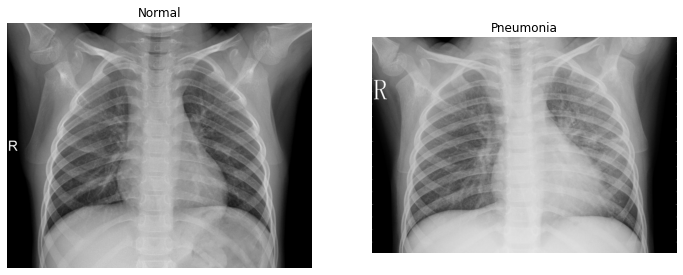

In [ ]:
# view a regular image file
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

file_normal = train_files_normal[0] # uses first normal filename from glob list
file_pneum = train_files_pneum[0] # uses first pneumonia filename from glob list

img_n = image.load_img(file_normal)
img_p = image.load_img(file_pneum)

# need subplot titles and each plot still
fig, ax = plt.subplots(figsize=(12,6),ncols=2)


ax[0].imshow(img_n)
ax[0].set(title='Normal')
ax[0].axis('off')

ax[1].imshow(img_p)
ax[1].set(title='Pneumonia')
ax[1].axis('off')
plt.show()


Test to view image as a tensor array. 

(1, 64, 64, 3)


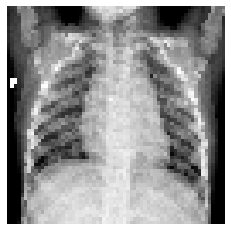

In [ ]:
feature_img = train_files_normal[1] # uses first normal filename from glob list

f_img = image.load_img(feature_img, target_size=(64,64))

# view as a tensor image
img_tensor = image.img_to_array(f_img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Follow the Original Model Preprocessing
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview an image
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

# Step 4: Modeling

## BUILD BASELINE CNN

In [ ]:
np.random.seed(111)
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
import datetime
from keras.callbacks import EarlyStopping



# timer for model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Initialising the CNN
model = Sequential()

# Step 1 - Convolution
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Step 2 - Pooling
model.add(layers.MaxPooling2D((2, 2)))

# Adding a second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
model.add(layers.MaxPooling2D((2, 2)))

# Adding a third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
model.add(layers.MaxPooling2D((2, 2)))

# Step 3 - Flattening
model.add(layers.Flatten())

# Step 4 - Full connection
model.add(layers.Dense(units = 512, activation = 'relu'))

model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'sgd', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(model.summary())

# Define the callbacks for early stopping of model based on val loss change.
early_stopping = [EarlyStopping(monitor='val_loss', min_delta= 0.01, patience=3)]
                

# Fitting the CNN to the images using fit_generator
history = model.fit(training_set,
                             steps_per_epoch = 500,
                             epochs = 10,
                            callbacks=early_stopping,
                             validation_data = val_set,
                             validation_steps =200, verbose=1, workers=-1)
# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4608)           

None

Epoch 1/10
500/500 [==============================] - 256s 512ms/step - loss: 0.5463 - acc: 0.7364 - val_loss: 0.3210 - val_acc: 0.8427
Epoch 2/10
500/500 [==============================] - 256s 513ms/step - loss: 0.3320 - acc: 0.8583 - val_loss: 0.3742 - val_acc: 0.8651
Epoch 3/10
500/500 [==============================] - 253s 507ms/step - loss: 0.2458 - acc: 0.8999 - val_loss: 0.2392 - val_acc: 0.8957
Epoch 4/10
500/500 [==============================] - 255s 510ms/step - loss: 0.2126 - acc: 0.9128 - val_loss: 0.1965 - val_acc: 0.9059
Epoch 5/10
500/500 [==============================] - 255s 510ms/step - loss: 0.1896 - acc: 0.9255 - val_loss: 0.2837 - val_acc: 0.8717
Epoch 6/10
500/500 [==============================] - 254s 508ms/step - loss: 0.1700 - acc: 0.9331 - val_loss: 0.2116 - val_acc: 0.9282
Epoch 7/10
500/500 [==============================] - 255s 509ms/step - loss: 0.1593 - acc: 0.9397 - val_loss: 0.2783 - val_acc: 0.9314
Training took a total of 0:29:44.957211


In [ ]:
# training loss and accuracy
results_train = model.evaluate(X_train, y_train)
results_train

4759/4759 [==============================] - 1s 218us/step


[13.539220279744773, 0.9554527997970581]

In [ ]:
# test loss and accuracy
results_test = model.evaluate(X_test, y_test)
results_test

624/624 [==============================] - 0s 212us/step


[57.79526121799763, 0.879807710647583]

In [ ]:
# # Your code here; save the model for future reference 
# model.save('baseline_model.h5')


### Interpreting Results

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       234
           1       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.87       624
weighted avg       0.88      0.88      0.88       624



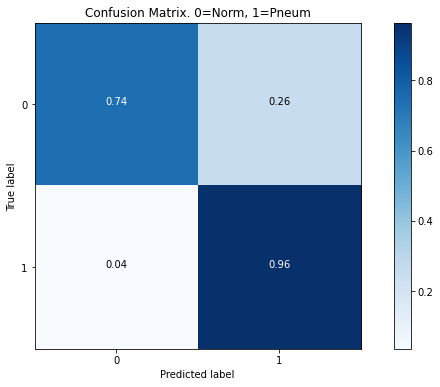

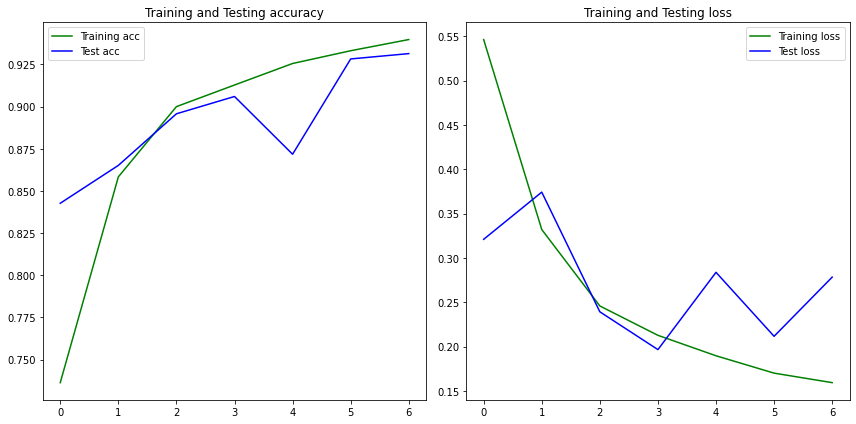

In [ ]:
y_preds = model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,history)

Training accuracy 95%. Test accuracy at 88% and loss at 58%. Pneumonia recall - 97%, F1 score 91.

# Visualize Feature Map Layers

This will help show you what's happening with the images after each layer of the model network and how the patterns are developed. 

In [ ]:
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:6]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4608)            

(1, 62, 62, 32)


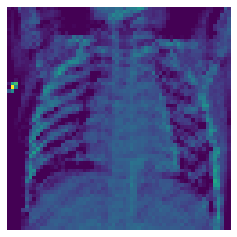

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.axis('off')
plt.show()

REPEAT FOR ALL LAYERS

IndexError: ignored

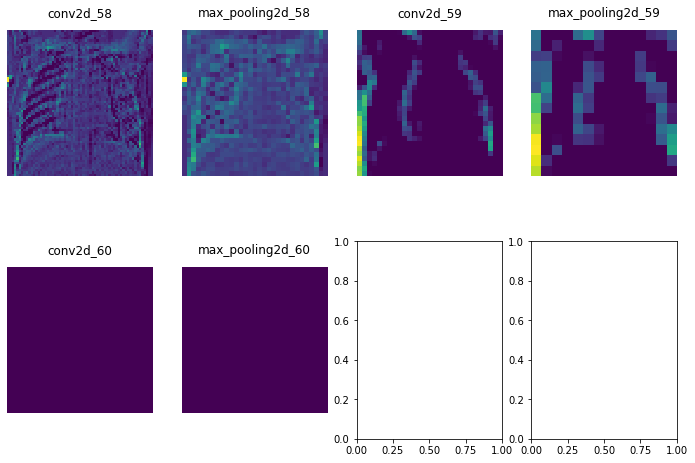

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.axis('off')
    ax.set_title(layer_names[i])

# Step 5: Model Hyperparams Updates

## Second model with RMSprop

In [ ]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime
from keras.callbacks import EarlyStopping



# timer for model
start = datetime.datetime.now()

# Initialising the CNN
rms_model = Sequential()

# Step 1 - Convolution
rms_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Step 2 - Pooling
rms_model.add(layers.MaxPooling2D((2, 2)))

# Adding a second convolutional layer
rms_model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
rms_model.add(layers.MaxPooling2D((2, 2)))

# Adding a third convolutional layer
rms_model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
rms_model.add(layers.MaxPooling2D((2, 2)))

# Step 3 - Flattening
rms_model.add(layers.Flatten())

# Step 4 - Full connection
rms_model.add(layers.Dense(units = 512, activation = 'relu'))

rms_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
rms_model.compile(optimizer = 'rmsprop', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(rms_model.summary())

# Define the callbacks for early stopping of model based on val loss change.
early_stopping = [EarlyStopping(monitor='val_loss', min_delta= 0.01, patience=3)]
                

# Fitting the CNN to the images using fit_generator
rms_history = rms_model.fit(training_set,
                             steps_per_epoch = 500,
                             epochs = 10,
                            callbacks=early_stopping,
                             validation_data = val_set,
                             validation_steps =200, verbose=1, workers=-1)

# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 4608)           

None

Epoch 1/10
500/500 [==============================] - 256s 512ms/step - loss: 0.3023 - acc: 0.8749 - val_loss: 0.1754 - val_acc: 0.9174
Epoch 2/10
500/500 [==============================] - 255s 509ms/step - loss: 0.1569 - acc: 0.9394 - val_loss: 0.0748 - val_acc: 0.9399
Epoch 3/10
500/500 [==============================] - 255s 510ms/step - loss: 0.1267 - acc: 0.9538 - val_loss: 0.4958 - val_acc: 0.9446
Epoch 4/10
500/500 [==============================] - 256s 511ms/step - loss: 0.1080 - acc: 0.9610 - val_loss: 0.2003 - val_acc: 0.9419
Epoch 5/10
500/500 [==============================] - 256s 512ms/step - loss: 0.0954 - acc: 0.9662 - val_loss: 0.0786 - val_acc: 0.9462
Training took a total of 0:21:18.111254


In [ ]:
# training loss and accuracy

results_train = rms_model.evaluate(X_train, y_train)
results_train

4759/4759 [==============================] - 1s 214us/step


[38.46056850480846, 0.9384324550628662]

In [ ]:
# test loss and accuracy

results_test = rms_model.evaluate(X_test, y_test)
results_test

624/624 [==============================] - 0s 227us/step


[72.4228279101543, 0.9150640964508057]

HOW TO SAVE h5 model

In [ ]:
# # Your code here; save the model for future reference 
# model.save('chest_xray_downsampled_data.h5')


HOW TO LOAD A PREVIOUS SAVED h5 model

In [ ]:
# from keras.models import load_model

# model = load_model('chest_xray_all_data.h5')
# # As a reminder 
# model.summary()  

### Interpreting Results

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       234
           1       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.92      0.91       624



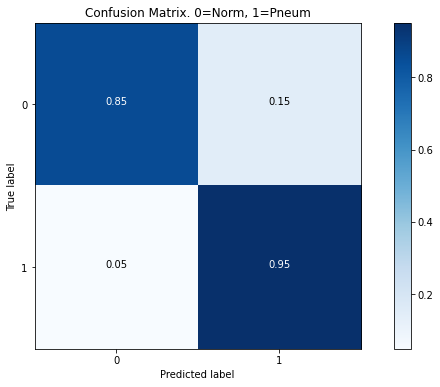

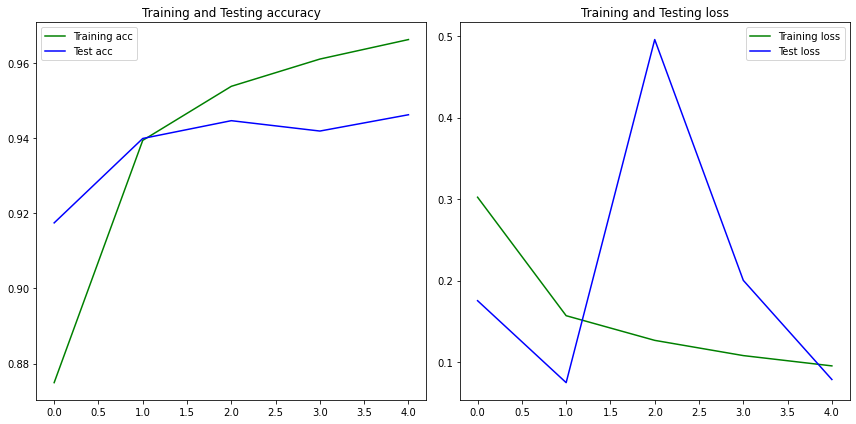

In [ ]:
y_preds = rms_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,rms_history)


Training accuracy 94%. Test accuracy at 92% and loss at 72%. Pneumonia recall - 95%, F1 score 93.

## Third model with ADAM

In [ ]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime
from keras.callbacks import EarlyStopping



# timer for model
start = datetime.datetime.now()

# Initialising the CNN
adam_model = Sequential()

# Step 1 - Convolution
adam_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Step 2 - Pooling
adam_model.add(layers.MaxPooling2D((2, 2)))

# Adding a second convolutional layer
adam_model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
adam_model.add(layers.MaxPooling2D((2, 2)))

# Adding a third convolutional layer
adam_model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
adam_model.add(layers.MaxPooling2D((2, 2)))

# Step 3 - Flattening
adam_model.add(layers.Flatten())

# Step 4 - Full connection
adam_model.add(layers.Dense(units = 512, activation = 'relu'))

adam_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
adam_model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(adam_model.summary())

# Define the callbacks for early stopping of model based on val loss change.
early_stopping = [EarlyStopping(monitor='val_loss', min_delta= 0.01, patience=3)]
                

# Fitting the CNN to the images using fit_generator
adam_history = adam_model.fit(training_set,
                             steps_per_epoch = 500,
                             epochs = 10,
                            callbacks=early_stopping,
                             validation_data = val_set,
                             validation_steps =200, verbose=1, workers=-1)

# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 4608)           

None

Epoch 1/10
500/500 [==============================] - 259s 517ms/step - loss: 0.2420 - acc: 0.9005 - val_loss: 0.1398 - val_acc: 0.9179
Epoch 2/10
500/500 [==============================] - 258s 516ms/step - loss: 0.1456 - acc: 0.9427 - val_loss: 0.2664 - val_acc: 0.9368
Epoch 3/10
500/500 [==============================] - 257s 514ms/step - loss: 0.1181 - acc: 0.9554 - val_loss: 0.2711 - val_acc: 0.9209
Epoch 4/10
500/500 [==============================] - 256s 513ms/step - loss: 0.1128 - acc: 0.9587 - val_loss: 0.2993 - val_acc: 0.9493
Training took a total of 0:17:10.934737


In [ ]:
# training loss and accuracy
results_train = adam_model.evaluate(X_train, y_train)
results_train

4759/4759 [==============================] - 1s 212us/step


[13.576785112738067, 0.9546123147010803]

In [ ]:
# test loss and accuracy
results_test = adam_model.evaluate(X_test, y_test)
results_test

624/624 [==============================] - 0s 216us/step


[49.79576932734404, 0.9006410241127014]

### Interpreting Results

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       234
           1       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



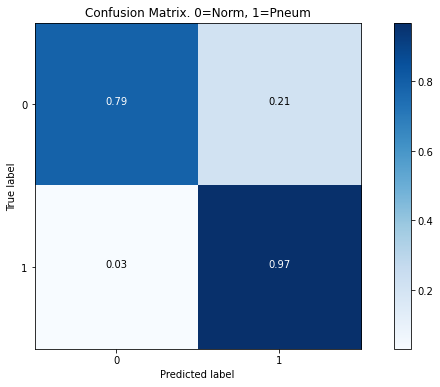

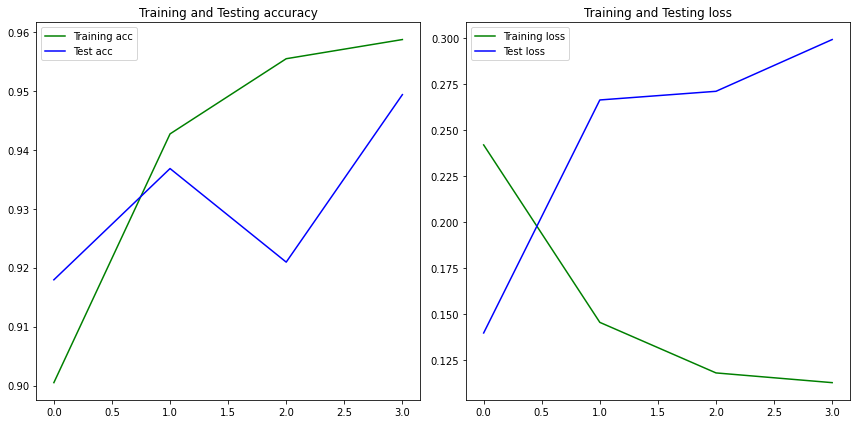

In [ ]:
y_preds = adam_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,adam_history)


Training accuracy 95%. Test accuracy at 90% and loss at 50%. Pneumonia recall - 97%, F1 score 92.

Best model so far for recall was adam with 90% accuracy and a recall of 97%. I'm going to move forward with the adam optimizer. 

- baseline sgd
Training accuracy 95%. Test accuracy at 88% and loss at 58%. Pneumonia recall - 97%, F1 score 91.  
- rmsprop
Training accuracy 94%. Test accuracy at 92% and loss at 72%. Pneumonia recall - 95%, F1 score 93.  
- adam
Training accuracy 95%. Test accuracy at 90% and loss at 50%. Pneumonia recall - 97%, F1 score 92.

## Fourth model with ADAM. Add Dropout. 

In [ ]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime
from keras.callbacks import EarlyStopping



# timer for model
start = datetime.datetime.now()

# Initialising the CNN
adam_drop_model = Sequential()

# Step 1 - Convolution
adam_drop_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Step 2 - Pooling
adam_drop_model.add(layers.MaxPooling2D((2, 2)))

# Adding a second convolutional layer
adam_drop_model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
adam_drop_model.add(layers.MaxPooling2D((2, 2)))

# Adding a third convolutional layer
adam_drop_model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
# Pooling
adam_drop_model.add(layers.MaxPooling2D((2, 2)))

# Step 3 - Flattening
adam_drop_model.add(layers.Flatten())

# Step 4 - Full connection
adam_drop_model.add(layers.Dense(units = 128, activation = 'relu'))

# Dropout applied to the full connection layer
adam_drop_model.add(layers.Dropout(0.3))

# Step 5 - Full connection
adam_drop_model.add(layers.Dense(units = 512, activation = 'relu'))

# output
adam_drop_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
adam_drop_model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(adam_drop_model.summary())

# Define the callbacks for early stopping of model based on val loss change.
early_stopping = [EarlyStopping(monitor='val_loss', min_delta= 0.01, patience=3)]
                

# Fitting the CNN to the images using fit_generator
adam_drop_history = adam_drop_model.fit(training_set,
                             steps_per_epoch = 500,
                             epochs = 10,
                            callbacks=early_stopping,
                             validation_data = val_set,
                             validation_steps =200, verbose=1, workers=-1)

# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 4608)           

None

Epoch 1/10
500/500 [==============================] - 256s 512ms/step - loss: 0.2793 - acc: 0.8810 - val_loss: 0.1483 - val_acc: 0.9357
Epoch 2/10
500/500 [==============================] - 255s 510ms/step - loss: 0.1571 - acc: 0.9392 - val_loss: 0.0613 - val_acc: 0.9427
Epoch 3/10
500/500 [==============================] - 256s 512ms/step - loss: 0.1268 - acc: 0.9546 - val_loss: 0.1829 - val_acc: 0.9475
Epoch 4/10
500/500 [==============================] - 255s 511ms/step - loss: 0.1090 - acc: 0.9587 - val_loss: 0.1235 - val_acc: 0.9523
Epoch 5/10
500/500 [==============================] - 255s 511ms/step - loss: 0.0950 - acc: 0.9646 - val_loss: 0.0348 - val_acc: 0.9465
Epoch 6/10
500/500 [==============================] - 257s 513ms/step - loss: 0.0870 - acc: 0.9674 - val_loss: 0.0935 - val_acc: 0.9463
Epoch 7/10
500/500 [==============================] - 255s 510ms/step - loss: 0.0841 - acc: 0.9693 - val_loss: 0.0807 - val_acc: 0.9518
Epoch 8/10
500/500 [============================

In [ ]:
# training loss and accuracy
results_train = adam_drop_model.evaluate(X_train, y_train)
results_train

4759/4759 [==============================] - 1s 213us/step


[15.08093405620532, 0.9617566466331482]

In [ ]:
# test loss and accuracy
results_test = adam_drop_model.evaluate(X_test, y_test)
results_test

624/624 [==============================] - 0s 219us/step


[78.91844392434145, 0.8926281929016113]


### Interpreting Results

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



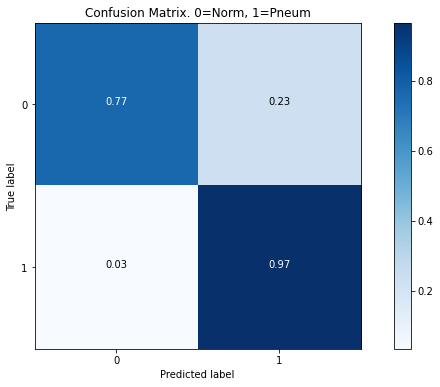

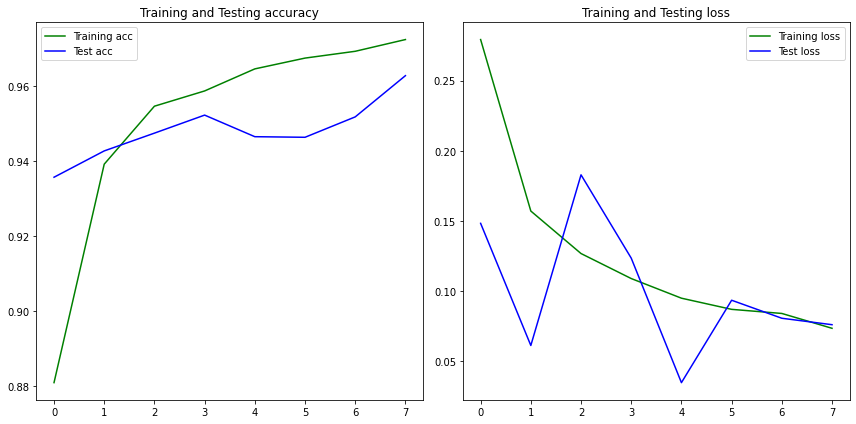

In [ ]:
y_preds = adam_drop_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,adam_drop_history)


Training accuracy 96%. Test accuracy at 89% and loss at 79%. Pneumonia recall - 97%, F1 score 89.  


In [ ]:
print('Adam model')
adam_y_preds = adam_model.predict_classes(X_test).flatten()
print(metrics.classification_report(y_test, adam_y_preds))
'\n'
print('Adam model with dropout')
dropout_y_preds = adam_drop_model.predict_classes(X_test).flatten()
print(metrics.classification_report(y_test, dropout_y_preds))

Adam model
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       234
           1       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

Adam model with dropout
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



Results: The Adam model with no dropout was better by only a slight amount with an accuracy of 90% compared to the dropout model's 89%. Both have a recall of pneumonia patients at 97%. Adam model with no dropout was better at not overfitting, with training acc of 95% and test acc of 90%. 

## Conclusion Summary

Based on this final Adam model without dropout, it seems that the process was able to classify 97% of all pneumonia patients in the test set. More tuning for the future to try and get more of the patients properly classified. 

With a high precision of 88% as well, the model is not only capturing a majority of the pneumonia case, but also being precise in diagnosis. Same goes for normal patients with a precision of 94%. 

CNN models are best for this type of work over dense layered networks. It uses such small images while still being able to break down the images using feature maps to search for patterns and accurately obtain results. Adjusting the model to work with higher res images could possibly increase accuracy performance with only a slight time increase.

Using this model adds technical advantages to aid in doctor review. It functions faster and better with image processing than a normal dense neural network. This will greatly increase processing time and cutting costs in the medical field and will allow labor hours to be redirected towards other pressing matters and care for more patients. It's recommended to use the model to scan lab images before doctor’s manual review. This will save on labor hours. Expenses can be allocated, diagnosis accuracy will go up, catching pneumonia earlier. Business reputation will go up. Patients will recognize the better care and work from the company. Using this model will also help to prevent human error. 
